# 3/2/2017

So today I will be comparing the photometry information from the brightest source in a Montage mosaic image (eight exposures) to the catalog.

In [1]:
#SEP extraction of mosaic images found using eight exposures in Montage

In [2]:
%matplotlib inline
import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy import wcs
from math import *
from matplotlib.patches import Ellipse

# Functions

In [3]:
# returns the indices of a list in descending order
def sort_reverse_index(x):
        return sorted(range(len(x)), key=lambda k: x.max()-x[k])
#returns indices of list in ascending order
def sort_index(x):
  return sorted(range(len(x)), key=lambda k: x[k])

In [4]:
#imports fits and puts into numpy array
def load_fits(filename):
    hdu_list = fits.open(filename, do_not_scale_image_data=True)
    tbdat = hdu_list[0].data
    tbdat = tbdat.byteswap().newbyteorder()
    return tbdat

In [5]:
#cuts the exposure images to 2000X2000, as the mosaic is just 2000X2000
def cut_exp(tbdat):
    tbdat = np.delete(tbdat, list(range(2000, 2036)),0)
    tbdat = np.delete(tbdat, list(range(2000, 2036)),1)
    return tbdat

The zero function finds the "zero point". The zero point it the magnitude of an object that produces one count per second. This value 'ABMAG' pulled from the fits header information.

In [6]:
#function gives zero point from exposure 1. All exposures should have the same zero point.
def zero(filename):
    hdu_list = fits.open(filename, do_not_scale_image_data=True)
    zero_point = hdu_list[0].header['ABMAG']
    return zero_point

In [7]:
#subtracts background from image
def subtraction(tbdat, bkg):
    bkg_rms = bkg.rms()	#background noise as 2d array
    tbdat_sub = tbdat - bkg #subtract background
    return tbdat_sub

The extraction function below performs the actual extraction on the image from which the background has been subtracted. There are several options that can be input here. They are:
    * Thresh - The detection threshold. A detected object is distinguished at this threshold (e.g 5.0*err).
    * err - In the below example is the global rms. 

In [8]:
#perform the extraction
def extraction(tbdat_sub, bkg):
    objects = sep.extract(tbdat_sub, thresh = 5.0, err = bkg.globalrms)
    return objects

The kron_info function below returns the Kron radius within an ellipse and any flags associated. The Kron radius is defined by Barbary (2016) as:
$$\sum_{i} r_{i}I(r_{i})/\sum_{i}I(r_{i})$$,
where $r_{i}$ is the distance to the pixel from the ellipse. The Kron aperature photometry is a proposed technique that captures the majority of the flux. $r$ in the function is the ellipse radius which is integrated over. 


In [9]:
#Gets kron radius information
def kron_info(objects, tbdat_sub):
    kronrad, kronflag = sep.kron_radius(tbdat_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], r=6.0)
    return kronrad, kronflag


The find_flux function below finds the flux, flux errors, and extraction flags from the background subtracted image. An elliptical apeture is used unless the $kr\sqrt{a * b}$ is smaller than a given radius, where kr, a, and b are the kron radius, semi-major, and semi-minor axes respectively. Then a circular appature is used. 

The sum_ellipse and sum_circle functions utalize the following inputs:
    * r - Scaling factor for a and b
    * subpix - subpixel sampling?
The flux error is calculated by
$$ \sigma^{2}_{F} = \sum_{i}\sigma^{2}_{i} + F/g$$
where $\sigma_i$ is the pixel noise, F is the sum in the aperature, and g is the gain.

The process of finding the Kron radius, performing elliptical aperature phtometry, and then circular aperture photomety (if kr is too small) is equivilent to FLUX_AUTO in SExtractor.
    
The flux_radius function returns the radius of a circle enclosing fraction of total flux (analogous to Kron radius for ellipse?). Inputs include:
    * frac - Requested fraction of light (0-1). E.g. frac=0.5 would give the radius of a circle contining half the      total flux of the object.
    * rmax - Max radius to analyze
    * normflux - a normalizing flux, rmax is used if not given
    
The winpos function returns paramteres used to get more accurate object centroid. From documentation: "On each iteration, the centroid is calculated using all pixels within a circular aperture of 4*sig from the current position, weighting pixel positions by their flux and the amplitude of a 2-d Gaussian with sigma sig. Iteration stops when the change in position falls under some threshold or a maximum number of iterations is reached." Sigma for the Gaussian is 2.0 / (2.35 * half light radius). 

In [10]:
#Finds flux, flux error, and extraction flags
def find_flux(tbdat_sub, bkg, objects, kronrad, kronflag):
    flux, fluxerr, flag = sep.sum_ellipse(tbdat_sub, objects['x'], objects['y'], objects['a'], objects['b'], objects['theta'], r = (2.5*kronrad), err = bkg.globalrms, subpix=1)
    flag |=kronflag #combines all flags
    r_min = 1.75 #minimum diameter = 3.5
    use_circle = kronrad * np.sqrt(objects['a'] * objects['b']) < r_min
    cflux, cfluxerr, cflag = sep.sum_circle(tbdat_sub, objects['x'][use_circle], objects['y'][use_circle], r_min, subpix=1)
    flux[use_circle] = cflux
    fluxerr[use_circle] = cfluxerr
    flag[use_circle] = cflag
    r, rflag = sep.flux_radius(tbdat_sub, objects['x'], objects['y'], rmax = 6.0*objects['a'], frac = 0.5, normflux = flux, subpix =5)
    sig = 2.0 / (2.35*r) # r from sep.flux_radius() above, with fluxfrac = 0.5
    xwin, ywin, wflag = sep.winpos(tbdat_sub, objects['x'], objects['y'], sig)
    return flux, fluxerr, flag, r, xwin, ywin


In [11]:
#convert extraction flux to AB magnitude
def magnitude(flux, zero_point):
#   flux = (flux * 1.841159e-20 / 10.7367601)/3.0e18
    mag = -2.5*np.log10(flux) + zero_point
    return mag

In [12]:
#reads in catalog used to generated exposures and puts info into arrays
def read_cat(filename):
    f = open(filename, "r")
    line = f.readlines()[1:]
    f.close()
    num_cat = np.array([])
    ra_cat = np.array([])
    dec_cat = np.array([])
    mag_cat = np.array([])
    z_cat = np.array([])
    s_cat = np.array([])
    a_cat = np.array([])
    b_cat = np.array([])
    theta_cat = np.array([])
    for i in range(len(line)):
        num_cat = np.append(num_cat, int(line[i].split()[0]))
        ra_cat = np.append(ra_cat, float(line[i].split()[1]))
        dec_cat = np.append(dec_cat, float(line[i].split()[2]))
        mag_cat = np.append(mag_cat, float(line[i].split()[3]))
        z_cat = np.append(z_cat, float(line[i].split()[4]))
        a_cat = np.append(a_cat, float(line[i].split()[5]))
        b_cat = np.append(b_cat, float(line[i].split()[6]))
        theta_cat = np.append(theta_cat, float(line[i].split()[7]))
        s_cat = np.append(s_cat, float(line[i].split()[9]))
    return num_cat, ra_cat, dec_cat, mag_cat, z_cat, s_cat, a_cat, b_cat, theta_cat

In [13]:
#convert pixel location of objectes extracted from image to ra and dec
def world(filename, objects):
    hdu_list = fits.open(filename)
    w = wcs.WCS(hdu_list[0].header)
    hdu_list.close()
    wrd = w.wcs_pix2world(objects['x'], objects['y'], 0) #double check this!!!!!
    ra = wrd[:][0]
    dec = wrd[:][1]
    return ra, dec

In [14]:
#convert pixel location of corners of image to ra and dec
def world_area(filename, tbdat):
    hdu_list = fits.open(filename)
    w = wcs.WCS(hdu_list[0].header)
    hdu_list.close()
    world_min = w.wcs_pix2world(0,0,0)
    world_max = w.wcs_pix2world(len(tbdat), len(tbdat), 0)
    return world_min, world_max

# Get Zero Point from Exposure 1

We need to first get the zero point (zp) from the first exposure's header info. This is used in converting flux to AB magnitude with the following equation:
$$ ABmag = -2.5log10(flux) + zp $$

All eight exposures have the same zero point for now. Will need to make this more general in the future.

In [15]:
fname_exp1 = 'simple_sim_cube_F090W_487_01.slp.fits'
tbdat_exp1 = load_fits(fname_exp1)
tbdat_exp1 = cut_exp(tbdat_exp1)
tbdat_exp1 = np.ascontiguousarray(tbdat_exp1) #Converts cut array to C-order memory
zero_point = zero(fname_exp1)

# Mosaic Image Extraction

Now I'll perform the source extraction on the mosaic image.

In [16]:
fname_img =  'F090W_8exp.fits'
tbdat = load_fits(fname_img)
bkg = sep.Background(tbdat) #measures background
tbdat_sub = subtraction(tbdat, bkg)
objects = extraction(tbdat_sub, bkg) #extraction of mosaic image
objects = objects[1:]
print('number of mosaic sources', len(objects['x']))
kronrad, kronflag = kron_info(objects, tbdat_sub) #Finds Kron Radius
flux, fluxerr, flag, r, xwin, ywin= find_flux(tbdat_sub, bkg, objects, kronrad, kronflag) #Finds flux from aperature phot.
mag = magnitude(flux, zero_point)

('number of mosaic sources', 153)


# Catalog Information

Next I'll get all of the info from the catalog

In [17]:
num_cat, ra_cat, dec_cat, mag_cat, z, s, a_cat, b_cat, theta_cat= read_cat('candels_with_fake_mag.cat')

# Get WCS Info of All Objects Extracted from Mosaic

I'll get RA/DEC info on all of the sources extracted from the mosaic.

In [18]:
ra, dec = world(fname_img, objects)

# Get RA & DEC of Exposure Area

Now I want to find the RA and DEC of the total area of the mosaic. I'll use this to plot the extracted sources over the mosaic image.

In [19]:
world_min, world_max = world_area(fname_img, tbdat)

# Delete Some Catalog Values

So as I noticed before, there are some sources in the catalog that are not within the area of the image. I'll delete those for my comparisons.

In [34]:
print "mosaic minimum RA/DEC", world_min[0], world_min[1]
print "mosaic maximum RA/DEC", world_max[0], world_max[1]
print "minimum RA/DEC in catalog", min(ra_cat), min(dec_cat)
print "maximum RA/DEC in catalog", max(ra_cat), max(dec_cat)

mosaic minimum RA/DEC 53.1013491735 -27.8137416937
mosaic maximum RA/DEC 53.1211772167 -27.7965842207
minimum RA/DEC in catalog 52.992519 -27.959661
maximum RA/DEC in catalog 53.270374 -27.656631


The above shows that there are indeed sources in the catalog that are outside of the mosaic area.

Now to delete those values.....

In [35]:
ra_cat_new = np.asarray([])
dec_cat_new = np.asarray([])
mag_cat_new = np.asarray([])
a_cat_new = np.asarray([])
b_cat_new = np.asarray([])
theta_cat_new = np.asarray([])
for i in range(len(ra_cat)):
    if (ra_cat[i] >= world_min[0]) and (ra_cat[i] <= world_max[0]):
        ra_cat_new = np.append(ra_cat_new, ra_cat[i])
        dec_cat_new = np.append(dec_cat_new, dec_cat[i])
        mag_cat_new = np.append(mag_cat_new, mag_cat[i])
        a_cat_new = np.append(a_cat_new, a_cat[i])
        b_cat_new = np.append(b_cat_new, b_cat[i])
        theta_cat_new = np.append(theta_cat_new, theta_cat[i])
ra_cat_cut = np.asarray([])
dec_cat_cut = np.asarray([])
mag_cat_cut = np.asarray([])
a_cat_cut = np.asarray([])
b_cat_cut = np.asarray([])
theta_cat_cut = np.asarray([])
for j in range(len(ra_cat_new)):
    if (dec_cat_new[j] >= world_min[1]) and (dec_cat_new[j] <= world_max[1]):
        ra_cat_cut = np.append(ra_cat_cut, ra_cat_new[j])
        dec_cat_cut = np.append(dec_cat_cut, dec_cat_new[j])
        mag_cat_cut = np.append(mag_cat_cut, mag_cat_new[j])
        a_cat_cut = np.append(a_cat_cut, a_cat_new[j])
        b_cat_cut = np.append(b_cat_cut, b_cat_new[j])
        theta_cat_cut = np.append(theta_cat_cut, theta_cat_new[j])

Let's print to make sure that I have indeed deleted those values.

In [36]:
print "mosaic minimum RA/DEC", world_min[0], world_min[1]
print "mosaic maximum RA/DEC", world_max[0], world_max[1]
print "minimum RA/DEC in catalog", min(ra_cat_cut), min(dec_cat_cut)
print "maximum RA/DEC in catalog", max(ra_cat_cut), max(dec_cat_cut)

mosaic minimum RA/DEC 53.1013491735 -27.8137416937
mosaic maximum RA/DEC 53.1211772167 -27.7965842207
minimum RA/DEC in catalog 53.101601 -27.813721
maximum RA/DEC in catalog 53.121082 -27.796585


Great, I did indeed delete all catalog sources outside of the mosaic image area.

# Plot Mosaic Image and Extracted Sources

Let's plot the mosaic image and the extracted sources over.


Personal note: Extent in imshow is "The location, in data-coordinates, of the lower-left and upper-right corners." Done as extent=[horizontal_min,horizontal_max,vertical_min,vertical_max]. 
The vmin and vmax values are set as a zscale range and can be used to show all exposures and image on the same scale.

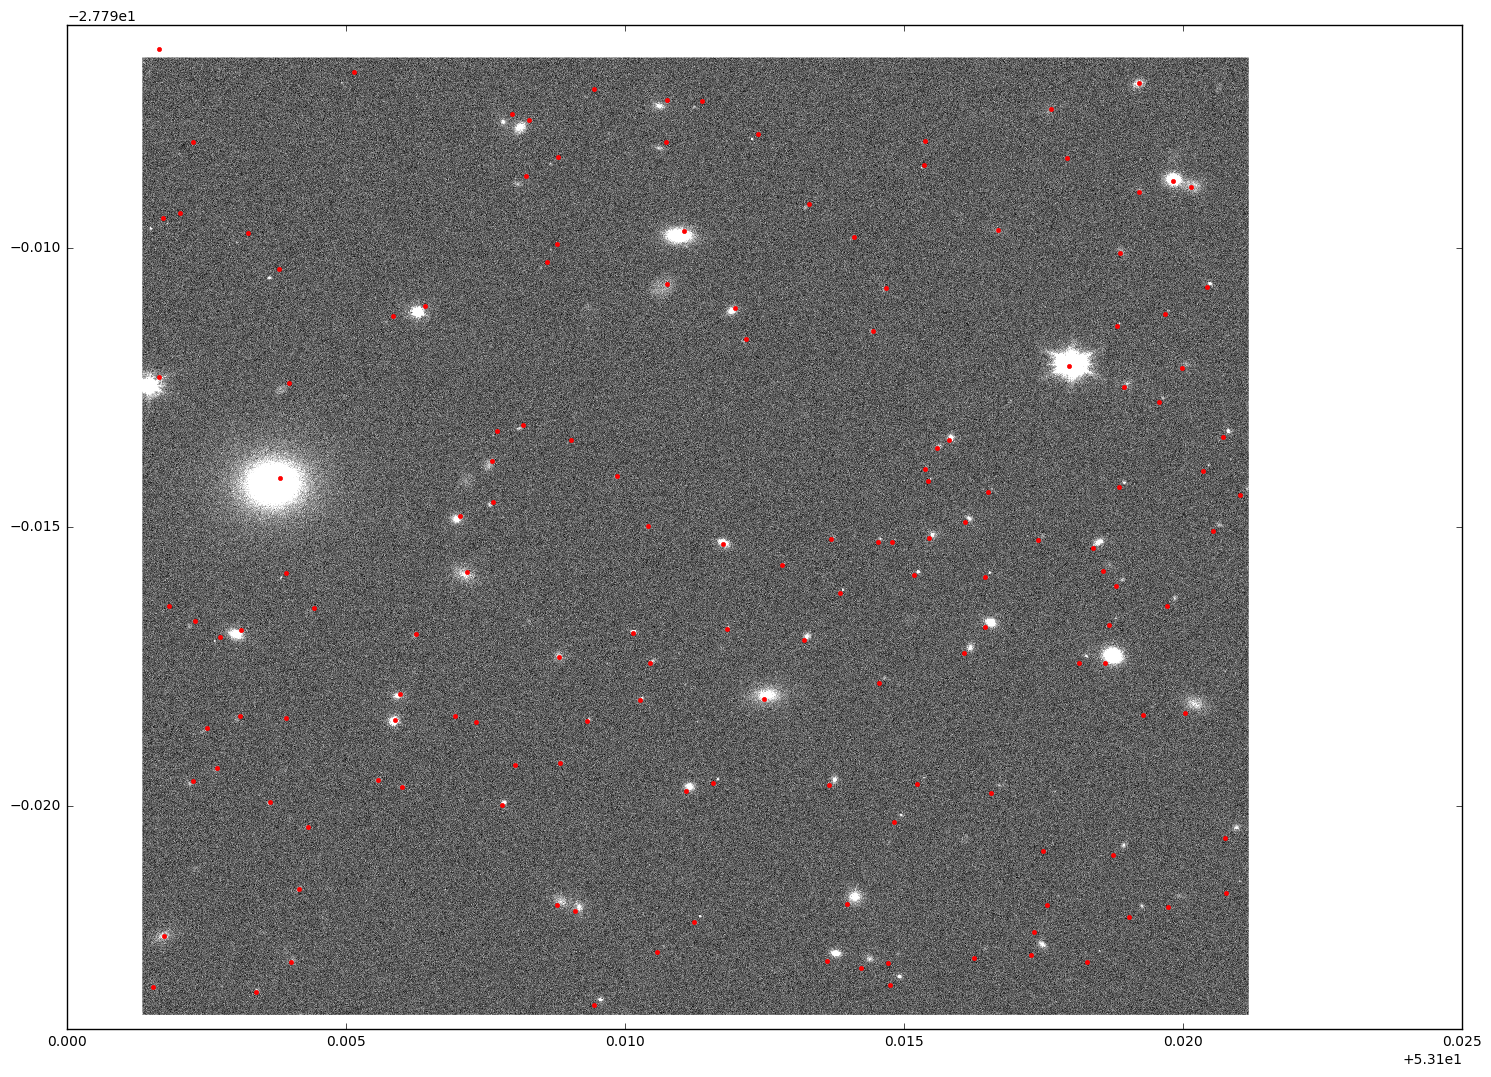

In [38]:
fig=plt.figure(figsize=(18, 16))
plt.imshow(tbdat_exp1, vmin=0.093537331, vmax=0.21167476, cmap='gray' ,interpolation='none', origin='lower', extent = [world_min[0], world_max[0], world_min[1], world_max[1]])
plt.plot(ra, dec, '.', color = 'red')

# List Brightest 25 Catalog Sources

To see some numbers let's list the 25 brightest sources given in the catalog.

In [40]:
#prints souces in magnitude increasing order with corresponding ra/dec (highest 50 flux)
index_cat_cut = sort_index(mag_cat_cut)
print "ABMag", "\t","RA", "\t\t", "DEC"
for j in range(0,25):
    k = index_cat_cut[j]
    print mag_cat_cut[k], "\t", ra_cat_cut[k], "\t", dec_cat_cut[k] 

ABMag 	RA 		DEC
17.962 	53.118019 	-27.802065
18.292 	53.103878 	-27.804071
19.217 	53.101707 	-27.80225
20.93 	53.10648 	-27.800976
21.017 	53.11866 	-27.807377
21.107 	53.111118 	-27.799646
21.773 	53.112545 	-27.80802
21.824 	53.119873 	-27.798738
22.346 	53.116508 	-27.806746
22.449 	53.105938 	-27.808401
22.652 	53.107235 	-27.805758
22.655 	53.103172 	-27.806795
22.716 	53.114033 	-27.811705
22.773 	53.111141 	-27.809668
22.816 	53.120098 	-27.808273
22.832 	53.111813 	-27.805244
23.021 	53.110813 	-27.800585
23.076 	53.107101 	-27.804749
23.079 	53.108341 	-27.797646
23.108 	53.120213 	-27.798853
23.138 	53.101795 	-27.812267
23.262 	53.113678 	-27.812729
23.296 	53.112038 	-27.80102
23.341 	53.118999 	-27.802444
23.496 	53.106022 	-27.807945


# List Brightest 25 Extracted Sources

List the brightes 25 extracted sources and their positions.

In [41]:
#prints souces in magnitude increasing order with corresponding ra/dec (highest 50 flux)
index = sort_index(mag)
print "ABMag", "\t\t","RA", "\t\t", "DEC"
for j in range(0,25):
    k = index[j]
    print mag[k], "\t", ra[k], "\t", dec[k] 

ABMag 		RA 		DEC
18.4268094933 	53.117958725 	-27.8021191931
18.6620934754 	53.1038203805 	-27.8041251497
19.4606619515 	53.1016539983 	-27.8023047073
21.0761976226 	53.1186012077 	-27.8074301038
21.1139271686 	53.1064199757 	-27.801029953
21.1682185062 	53.1110582431 	-27.799699403
21.5215257379 	53.1201430624 	-27.7989002166
21.6772457172 	53.1198163618 	-27.7987916485
21.8800745742 	53.1124852832 	-27.8080741588
22.5027888452 	53.116450028 	-27.8067989841
22.5912262512 	53.1058806837 	-27.8084544859
22.7169735595 	53.1031138322 	-27.8068488684
22.7552326581 	53.1071740868 	-27.8058114128
22.7945389894 	53.1139745784 	-27.8117595509
22.8995229283 	53.1200390115 	-27.8083258539
22.9321684372 	53.1087840345 	-27.8117743493
22.9437138455 	53.1117555181 	-27.8052971095
23.0160816599 	53.1110834311 	-27.809721568
23.026659634 	53.1082811139 	-27.7976995574
23.0839938467 	53.1107545491 	-27.8006383789
23.2482567108 	53.1070434668 	-27.8048027539
23.30233987 	53.1017372228 	-27.8123219597
2

A quick scan shows that there are discrepancies between the AB magnitudes of the catalog and extracted sources.

# Mosaic and Catalog Comparison

I'll print the brightest source in the catalog and extracted source list. Here we can compare the AB Mag, position, and elliptical properties of the two.

In [45]:
pix_scale = 0.0317
bright_cat = index_cat_cut[0]
elip_cat = 1 - (b_cat_cut[bright_cat]/a_cat_cut[bright_cat])
print "CATALOG:"
print "AB_mag", "\t", "RA", "\t", "DEC", "\t\t", "a(arcsec)", "\t", "b(arcsec)", "\t", "ellipticity", "\t", "theta", "\t"
print mag_cat_cut[bright_cat], "\t", round(ra_cat_cut[bright_cat],3), "\t", round(dec_cat_cut[bright_cat],3), "\t", a_cat_cut[bright_cat], "\t\t", b_cat_cut[bright_cat], "\t\t", round(elip_cat,3), "\t\t",  theta_cat_cut[bright_cat]
print
index = sort_index(mag)
bright = index[0]
a = objects['a'][bright]*pix_scale #convert from pix units to arc sec
b = objects['b'][bright]*pix_scale
theta = objects['theta'][bright]
elip = 1 - (b/a)
print "Mosaic"
print "AB_mag", "\t", "RA", "\t", "DEC", "\t\t", "a(arcsec)", "\t", "b(arcsec)", "\t", "ellipticity", "\t", "theta", "\t"
print round(mag[bright],3), "\t", round(ra[bright],3), "\t", round(dec[bright],3), "\t", round(a,2), "\t\t", round(b,3), "\t\t", round(elip,3), "\t\t", round(theta*180./np.pi,3)
print
print "flags:"
print objects['flag'][bright]

CATALOG:
AB_mag 	RA 	DEC 		a(arcsec) 	b(arcsec) 	ellipticity 	theta 	
17.962 	53.118 	-27.802 	0.036 		0.033 		0.083 		-29.698

Mosaic
AB_mag 	RA 	DEC 		a(arcsec) 	b(arcsec) 	ellipticity 	theta 	
18.427 	53.118 	-27.802 	0.25 		0.227 		0.097 		-9.794

flags:
0


So these appear to be the same source given their RAs/DECs. The magnitudes are off by ~0.5. The elliptical properties don't match, but that might not be cause for concern as this source is a star and most likely uses circular apperature photometry. 

Let's plot to make sure I am comparing the same source.

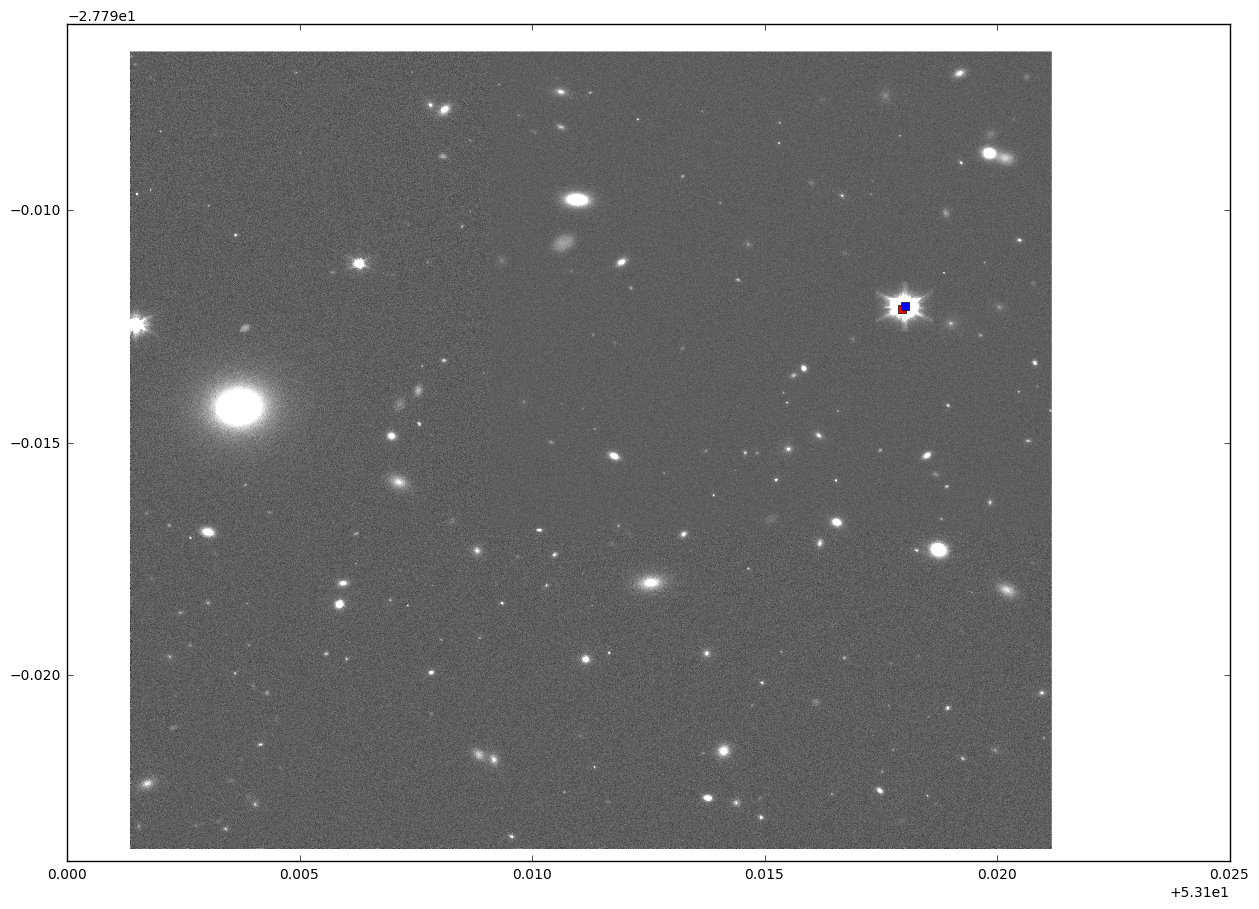

In [44]:
fig, ax =plt.subplots(figsize=(15, 15))
im = ax.imshow(tbdat, vmin=0.093537331, vmax=0.21167476, cmap = 'gray', interpolation='none', origin='lower', extent = [world_min[0], world_max[0], world_min[1], world_max[1]])
plt.plot(ra[bright], dec[bright], marker = "s", color = 'red')
plt.plot(ra_cat_cut[bright_cat], dec_cat_cut[bright_cat], marker = "s", color = 'blue')

Yep, same source.

Previously I extracted the same source from a Montage mosaic that only used four exposures. Let's note how they compare.

CATALOG:

AB_mag &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; RA &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; DEC &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a(arcsec) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b(arcsec) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ellipticity &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; theta 	
17.962 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 53.118 &nbsp;&nbsp;&nbsp; -27.802 &nbsp;&nbsp;&nbsp;&nbsp; 0.036 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.033 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.083 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -29.698

Mosaic (8 exp)

AB_mag &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; RA &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; DEC &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a(arcsec) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b(arcsec) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ellipticity &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; theta 	
18.427 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 53.118 &nbsp;&nbsp;&nbsp; -27.802 &nbsp;&nbsp;&nbsp;&nbsp; 0.25 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.227 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.097 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -9.794 		 		 		

Mosaic (4 exp)

AB_mag &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; RA &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; DEC &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a(arcsec) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b(arcsec) &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ellipticity &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; theta 	
18.452 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 53.118 &nbsp;&nbsp;&nbsp; -27.802 &nbsp;&nbsp;&nbsp;&nbsp; 0.22 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.195  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 0.11 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -9.511
 				 		

I thought using eight exposures might decrease the difference in magnitudes between the catalog and the mosaic, but it unfortunatly did not. Brant mentioned that it might be the case that the catalog quotes a total magnitude. In that case 0.5 is not an unreasonable error. 